<a href="https://colab.research.google.com/github/gj0210/CMP7239/blob/main/jyot%20Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

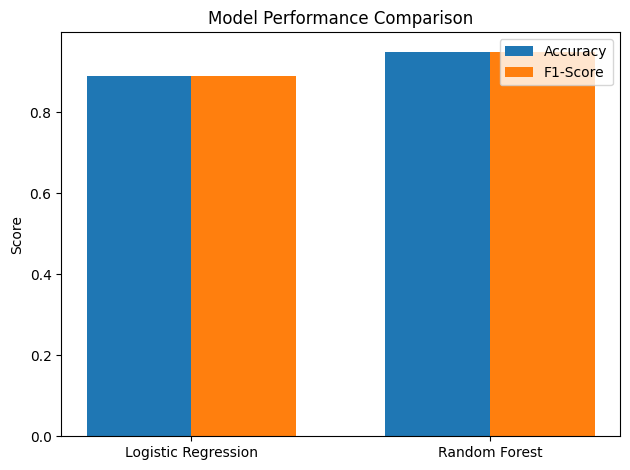

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example data from your model's output
models = ['Logistic Regression', 'Random Forest']
accuracy = [0.89, 0.95]
f1_score = [0.89, 0.95]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_score, width, label='F1-Score')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
fig.tight_layout()
plt.show()

In [3]:
import pandas as pd
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import zipfile
import os

# --- 0. EXTRACT DATASET ---
print("--- Step 0: Extracting Dataset ---")
zip_file_path = '/content/archive(6).zip'
extracted_dir_path = '/content/extracted_data'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir_path)
    print(f"Successfully extracted data to {extracted_dir_path}")
except FileNotFoundError:
    print(f"Error: The zip file at '{zip_file_path}' was not found.")
    exit()
except zipfile.BadZipFile:
    print(f"Error: The file at '{zip_file_path}' is not a valid zip file.")
    exit()


# --- 1. DATA LOADING AND EXPLORATORY DATA ANALYSIS (EDA) ---
print("\n--- Step 1: Loading Dataset and Initial Analysis ---")

# The path to your extracted file.
file_path = os.path.join(extracted_dir_path, 'urls.csv')

try:
    # Read the CSV file into a pandas DataFrame.
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print("\nInitial Data Preview:")
    display(df.head())
    print("\nDataFrame Info:")
    df.info()

    # Check the class distribution. The 'category' column contains our labels.
    print("\nClass Distribution (Legitimate vs. Phishing):")
    print(df['category'].value_counts())

    # We will create a binary target variable: 1 for 'Phishing' and 0 otherwise.
    df['is_phishing'] = df['category'].apply(lambda x: 1 if x == 'Phishing' else 0)
    print("\nBinary Target Variable Distribution:")
    print(df['is_phishing'].value_counts())

except FileNotFoundError:
    print(f"Error: The file at '{file_path}' was not found. Please ensure the file path is correct after extraction.")
    # Exit the script gracefully if the file isn't found
    exit()

# --- 2. FEATURE ENGINEERING ---
print("\n--- Step 2: Feature Engineering ---")

def extract_url_features(url):
    """
    Extracts numerical features from a given URL string.

    Args:
        url (str): The URL to analyze.

    Returns:
        dict: A dictionary of extracted features.
    """
    try:
        parsed_url = urlparse(url)

        # 1. URL Length
        length = len(url)

        # 2. Number of special characters in the URL
        special_chars = len(re.findall(r'[!@#$%^&*()_+={}\[\]|\\:;"<,>.?/`~]', url))

        # 3. Number of dots
        num_dots = url.count('.')

        # 4. Use of IP address instead of a domain name
        # A simple regex to check for a pattern like 127.0.0.1
        ip_in_url = 1 if re.match(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$', parsed_url.hostname or '') else 0

        # 5. Presence of a hyphen in the hostname
        has_hyphen = 1 if '-' in (parsed_url.hostname or '') else 0

        # 6. Presence of '@' symbol
        has_at_symbol = 1 if '@' in url else 0

        # 7. Number of slashes in the path
        num_slashes = url.count('/')

        # Return the features as a dictionary
        return {
            'url_length': length,
            'special_chars_count': special_chars,
            'num_dots': num_dots,
            'ip_in_url': ip_in_url,
            'has_hyphen': has_hyphen,
            'has_at_symbol': has_at_symbol,
            'num_slashes': num_slashes,
        }
    except Exception as e:
        # Handle cases where URL parsing fails
        return {
            'url_length': 0,
            'special_chars_count': 0,
            'num_dots': 0,
            'ip_in_url': 0,
            'has_hyphen': 0,
            'has_at_symbol': 0,
            'num_slashes': 0,
        }

# Apply the feature extraction function to the 'url' column.
features_df = df['url'].apply(extract_url_features)
features_df = pd.DataFrame(features_df.tolist())

# Combine the features DataFrame with the target variable.
data = pd.concat([features_df, df['is_phishing']], axis=1)

print("\nEngineered Features Preview:")
display(data.head())

# --- 3. DATA PREPARATION ---
print("\n--- Step 3: Data Preparation ---")
X = data.drop('is_phishing', axis=1)
y = data['is_phishing']

# Split the data into training and testing sets (80% train, 20% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# --- 4. MODEL TRAINING ---
print("\n--- Step 4: Model Training ---")

# Train Logistic Regression Model (our baseline)
print("Training Logistic Regression model...")
log_reg_model = LogisticRegression(solver='liblinear', random_state=42)
log_reg_model.fit(X_train, y_train)

# Train Random Forest Classifier (our main model)
print("Training Random Forest Classifier model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# --- 5. MODEL EVALUATION ---
print("\n--- Step 5: Model Evaluation ---")

# Evaluate Logistic Regression
print("=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=")
print("  Logistic Regression Performance  ")
print("=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=")
y_pred_log_reg = log_reg_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Legitimate', 'Phishing']))
print("Overall Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))

# Evaluate Random Forest
print("\n\n=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=")
print("  Random Forest Performance  ")
print("=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=")
y_pred_rf = rf_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Legitimate', 'Phishing']))
print("Overall Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

--- Step 0: Extracting Dataset ---
Successfully extracted data to /content/extracted_data

--- Step 1: Loading Dataset and Initial Analysis ---
Dataset loaded successfully.

Initial Data Preview:


,name,url,category,subcategory,description,addresses,reporter
0,xn--myetherwallt-leb.com,http://xn--myetherwallt-leb.com,Phishing,MyEtherWallet,Google reports site as insecure,NaN,CryptoScamDB
1,myelherwallel.com,http://myelherwallel.com,Phishing,MyEtherWallet,NaN,{'ETH': ['0xD0cC2B24980CBCCA47EF755Da88B220a82...,CryptoScamDB
2,myetherwallet.cam,http://myetherwallet.cam,Phishing,MyEtherWallet,redirecting to real site but that happened before,NaN,CryptoScamDB
3,coindash.ru,http://coindash.ru,Phishing,Coindash,someone plz check,NaN,CryptoScamDB
4,coin-wallet.info,http://coin-wallet.info,Phishing,Coindash,scam wallet,NaN,CryptoScamDB



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9889 entries, 0 to 9888
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         9889 non-null   object
 1   url          9889 non-null   object
 2   category     9889 non-null   object
 3   subcategory  9876 non-null   object
 4   description  8011 non-null   object
 5   addresses    4332 non-null   object
 6   reporter     9886 non-null   object
dtypes: object(7)
memory usage: 540.9+ KB

Class Distribution (Legitimate vs. Phishing):
category
Phishing    5946
Scamming    3875
Malware       67
Hacked         1
Name: count, dtype: int64

Binary Target Variable Distribution:
is_phishing
1    5946
0    3943
Name: count, dtype: int64

--- Step 2: Feature Engineering ---

Engineered Features Preview:


,url_length,special_chars_count,num_dots,ip_in_url,has_hyphen,has_at_symbol,num_slashes,is_phishing
0,31,4,1,0,1,0,2,1
1,24,4,1,0,0,0,2,1
2,24,4,1,0,0,0,2,1
3,18,4,1,0,0,0,2,1
4,23,4,1,0,1,0,2,1



--- Step 3: Data Preparation ---
Training set size: 7911 samples
Testing set size: 1978 samples

--- Step 4: Model Training ---
Training Logistic Regression model...
Training Random Forest Classifier model...

--- Step 5: Model Evaluation ---
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
  Logistic Regression Performance  
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.58      0.36      0.45       803
    Phishing       0.65      0.82      0.73      1175

    accuracy                           0.64      1978
   macro avg       0.62      0.59      0.59      1978
weighted avg       0.63      0.64      0.62      1978

Overall Accuracy: 0.6365015166835187

Confusion Matrix:
[[293 510]
 [209 966]]


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
  Random Forest Performance  
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.58    

from matplotlib import pyplot as plt
_df_0['url_length'].plot(kind='hist', bins=20, title='url_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['has_hyphen'].plot(kind='hist', bins=20, title='has_hyphen')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='url_length', y='has_hyphen', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['special_chars_count']
  ys = series['url_length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('special_chars_count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('special_chars_count')
_ = plt.ylabel('url_length')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['special_chars_count']
  ys = series['has_hyphen']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('special_chars_count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('special_chars_count')
_ = plt.ylabel('has_hyphen')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['special_chars_count']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'special_chars_count'}, axis=1)
              .sort_values('special_chars_count', ascending=True))
  xs = counted['special_chars_count']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('special_chars_count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('special_chars_count')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['num_dots']
  ys = series['url_length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('num_dots', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('num_dots')
_ = plt.ylabel('url_length')

from matplotlib import pyplot as plt
_df_7['url_length'].plot(kind='line', figsize=(8, 4), title='url_length')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['has_hyphen'].plot(kind='line', figsize=(8, 4), title='has_hyphen')
plt.gca().spines[['top', 'right']].set_visible(False)